In [38]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

In [39]:
data_directory = pathlib.Path('./dataset/val-cat-rabbit')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['cat', 'rabbit']


In [40]:
rabbit_dir="./dataset/val-cat-rabbit/rabbit"
cat_dir="./dataset/val-cat-rabbit/rabbit"
data_dir="./dataset/val-cat-rabbit"

In [41]:
num_rabbit_images = len(os.listdir(data_dir))
num_cat_images = len(os.listdir(cat_dir))
print(f'Number of rabbit images: {num_rabbit_images}')
print(f'Number of cat images: {num_cat_images}')

Number of rabbit images: 2
Number of cat images: 207


In [42]:
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 332 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


In [43]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [44]:
def plot_random_images():
    """
    Plots 35 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()       
    plt.show()

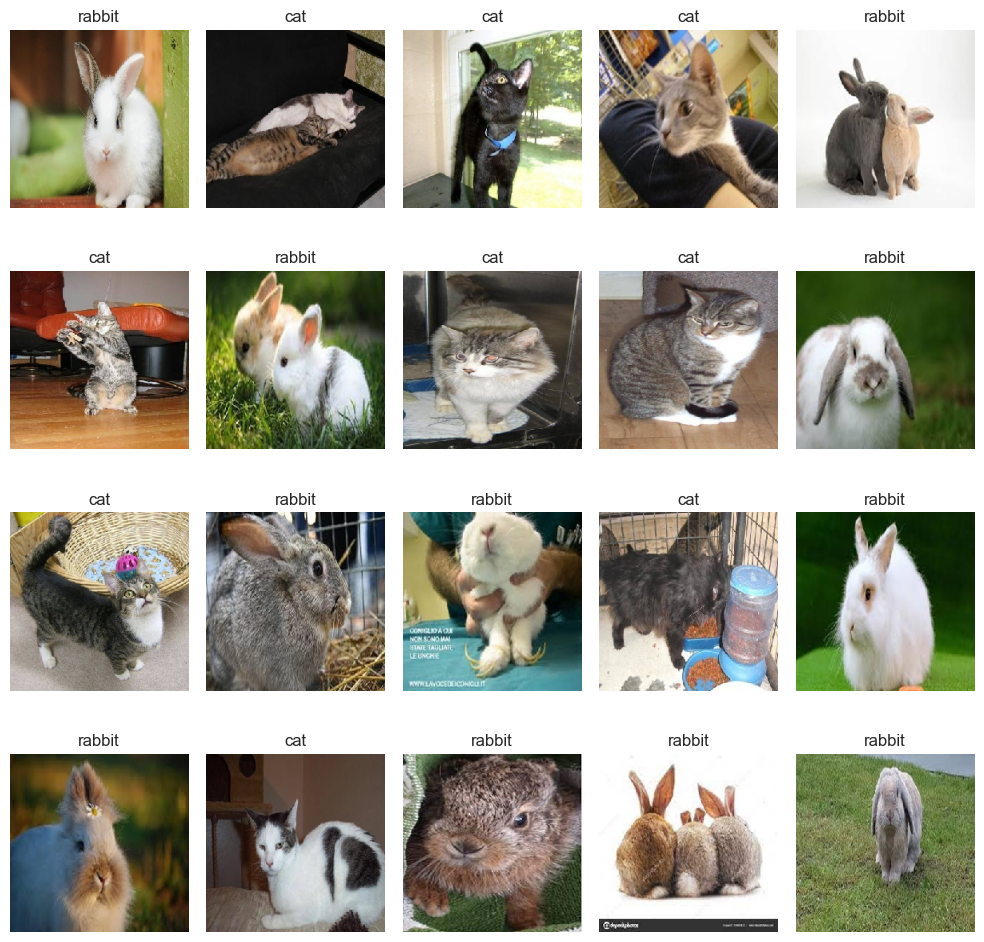

In [45]:
plot_random_images()

In [46]:
train_data, val_data

(<keras.preprocessing.image.DirectoryIterator at 0x22496a5e2c8>,
 <keras.preprocessing.image.DirectoryIterator at 0x22495df6948>)

In [47]:
model = tf.keras.Sequential([
            tf.keras.Input(shape = images[0].shape),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(2, activation = 'softmax'),
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [49]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [50]:
classifier = model.fit(train_data, batch_size = 32, 
                                 epochs = 12, 
                                 validation_data = val_data, 
                                 verbose = 1,
                                 callbacks = [reduce_lr])

Epoch 1/12
11/11 [==============================] - 26s 2s/step - loss: 3.4275 - accuracy: 0.5120 - val_loss: 0.7100 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 2/12
11/11 [==============================] - 18s 2s/step - loss: 0.6767 - accuracy: 0.5934 - val_loss: 0.7336 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 3/12
11/11 [==============================] - 17s 2s/step - loss: 0.6332 - accuracy: 0.6446 - val_loss: 0.7197 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 4/12
11/11 [==============================] - 15s 1s/step - loss: 0.5106 - accuracy: 0.7530 - val_loss: 0.8609 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 5/12
11/11 [==============================] - 15s 1s/step - loss: 0.3355 - accuracy: 0.8373 - val_loss: 0.7909 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 6/12
11/11 [==============================] - 15s 1s/step - loss: 0.2182 - accuracy: 0.9247 - val_loss: 0.8512 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 7/12
11/11 [==============================] - 15s 1s/step - loss: 0.1058 - a

In [51]:
model.evaluate(val_data)

3/3 [==============================] - 1s 270ms/step - loss: 1.4857 - accuracy: 0.7195


[1.4856740236282349, 0.7195122241973877]

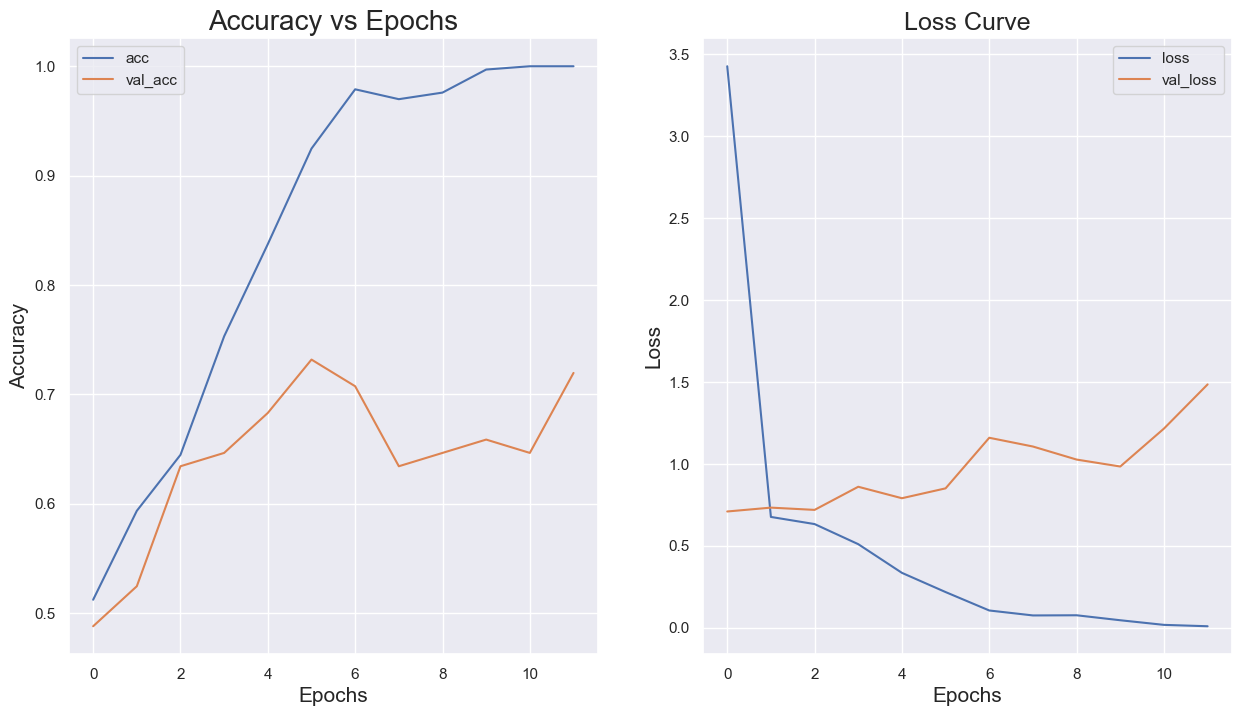

In [52]:
def model_performance_graphs():
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs()


In [53]:
model.save("CNN.h5")

In [54]:
loaded_model = tf.keras.models.load_model('CNN.h5')
loaded_model

In [55]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0
    
    return img_preprocessed

1/1 [==============================] - 0s 61ms/step
Predicted class: cat


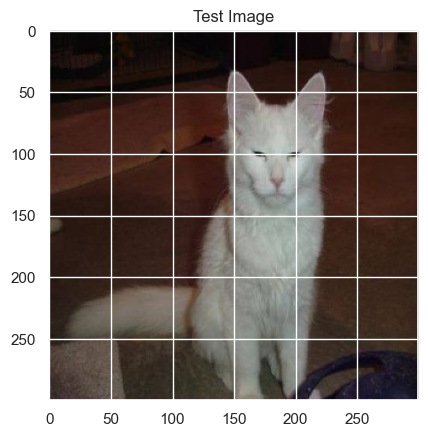

In [66]:
img_path ="./dataset/test-images/cat/cat.234.jpg"
img = preprocess_images(img_path)

prediction = loaded_model.predict(img)
predicted_class_index = np.argmax(prediction)
class_labels = ['cat', 'rabbit']  
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

# Membaca gambar dari path file
img = mpimg.imread(img_path)

# Menampilkan gambar
plt.imshow(img)
plt.title(f"Test Image")
plt.show()

1/1 [==============================] - 0s 70ms/step
Predicted class: rabbit


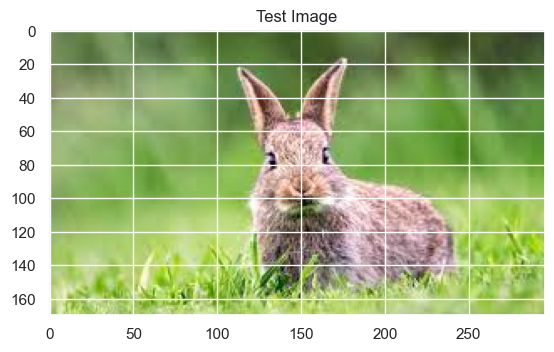

In [70]:
img_path ="./dataset/test-images/rabbit/rabbit_test.jpeg"
img = preprocess_images(img_path)

prediction = loaded_model.predict(img)
predicted_class_index = np.argmax(prediction)
class_labels = ['cat', 'rabbit']  
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

# Membaca gambar dari path file
img = mpimg.imread(img_path)

# Menampilkan gambar
plt.imshow(img)
plt.title(f"Test Image")
plt.show()